# 03 BMRA

Run BMRA based on global responses derived from the pathway activity predictions.

In [1]:
import pandas as pd
import numpy as np
import os
import bmra

In [3]:
data_dir_1 = "01_outputs_2020"
data_dir_2 = "02_outputs_2020"
info_dir = "~/Phd_project/project_GBM/gbm_Scripts/gbm_Scripts_bmra_u251mg/00_outputs_2020_U251MG"
out_dir = "03_outputs_2020"


os.makedirs(out_dir, exist_ok = True)

## Load data

### Global responses

Assembled from global responses calculated from predicted pathway activities, and DPD global responses.

In [4]:
def assemble_R_global(pathway_rglobal_file, dpd_rglobal_file):
    """
    Assemble full R_global matrix
    """
    R_global_modules_df = pd.read_csv(pathway_rglobal_file, index_col = 0)

    perts = R_global_modules_df.columns.tolist()

    R_global_DPD_df = pd.read_csv(dpd_rglobal_file, index_col=0).T

    # filter by perts list
    R_global_DPD_df = R_global_DPD_df[R_global_DPD_df.index.isin(perts)]

    # sort by perts list
    R_global_DPD_df["sort_col"] = R_global_DPD_df.index.map({val: i for i, val in enumerate(perts)})
    R_global_DPD_df = R_global_DPD_df.sort_values("sort_col")
    R_global_DPD_df = R_global_DPD_df.drop("sort_col", axis = 1)

    # transpose
    R_global_DPD_df = R_global_DPD_df.T

    R_global_df = pd.concat([R_global_modules_df, R_global_DPD_df])

    return R_global_df

In [5]:
R_global_df = assemble_R_global(
    pathway_rglobal_file = os.path.join(data_dir_2, "R_global_annotated.csv"),
    dpd_rglobal_file = os.path.join(data_dir_1, "R_global_DPDonly_annotated.csv"),
)

modules = R_global_df.index.tolist()
exp_ids = R_global_df.columns.tolist()

R_global = R_global_df.values
n_modules = R_global.shape[0]

print(R_global.shape)
display(R_global_df)

(12, 98)


,ASG002_U251MG_24H:A10,ASG002_U251MG_24H:A11,ASG002_U251MG_24H:A12,ASG002_U251MG_24H:A19,ASG002_U251MG_24H:A20,ASG002_U251MG_24H:A21,ASG002_U251MG_24H:B10,ASG002_U251MG_24H:B11,ASG002_U251MG_24H:B12,ASG002_U251MG_24H:B13,...,ASG002_U251MG_24H:O12,ASG002_U251MG_24H:O13,ASG002_U251MG_24H:O14,ASG002_U251MG_24H:O15,ASG002_U251MG_24H:O22,ASG002_U251MG_24H:O23,ASG002_U251MG_24H:O24,ASG002_U251MG_24H:P16,ASG002_U251MG_24H:P17,ASG002_U251MG_24H:P18
CDK1,0.081358,0.122608,0.173062,-0.614592,0.266150,-0.896698,-0.760904,-0.803477,-0.029663,-0.945355,...,0.286703,0.152635,0.215968,0.297845,0.177967,-0.392996,0.156267,-0.471839,0.189555,-0.487124
CDK2,0.106291,0.117066,0.009879,0.098416,0.053292,0.060298,0.086446,0.066069,0.094024,0.064853,...,0.008412,0.014318,0.021080,0.036217,0.027758,-0.001768,0.047324,0.050914,0.094637,-0.162118
CDK4_6,-0.392729,-0.013477,0.138345,-0.309113,0.001109,-0.597966,-0.383819,-0.248611,-0.059019,-1.643305,...,0.337780,-0.104207,-0.123022,0.450489,-0.049429,0.068921,-0.013531,-1.813971,-1.731328,-1.090763
PI3K,-1.729945,-1.923107,-1.579807,-1.766978,-1.359502,-0.459762,-0.091445,-0.141465,-0.360043,-0.483704,...,-0.553317,-1.046034,0.472570,-1.020177,-1.449277,-1.431845,-0.862150,-1.074738,-1.142248,-0.761477
ERK,-0.056256,-0.910588,-0.579399,-1.369207,-0.237407,-0.074648,-0.052447,0.029301,0.071882,0.243400,...,-0.517928,-1.977276,-1.642834,-1.597361,-1.648355,-1.868634,-1.976509,-0.569702,-1.975754,-0.282942
PDGFR,-1.673658,-0.121245,-0.608819,-0.103241,-0.552716,-0.669133,0.035077,0.067963,0.121428,0.163953,...,-1.118310,-1.519820,-0.415189,-1.327737,-0.535055,-0.053033,-0.715650,-1.857551,-1.000883,-0.340180
Aurora,0.390676,-0.868365,0.130717,0.536593,0.582838,-1.997585,-1.329816,-1.644541,-1.583619,-1.070000,...,0.152283,-1.002509,-0.457189,0.318413,-0.201817,0.633230,0.635859,-0.908544,-1.063241,-0.523690
Estrogen,0.178508,-0.060196,-0.460387,0.059269,-1.570905,-0.186924,-0.070257,0.116651,0.111048,0.154403,...,-1.395481,-0.307969,-0.315300,-0.317254,-0.626320,-0.101909,-1.546800,-0.857482,-0.177886,0.786530
EGFR,-0.247294,-1.110090,0.864011,-1.969531,-0.573473,-1.019544,-0.859004,-1.118882,-1.316839,-1.928089,...,0.996038,-1.176345,0.951608,-0.924067,-1.171091,0.973031,-0.725879,-0.704517,-0.729730,-0.316604
p53,-0.247018,0.238750,0.089139,0.117104,-0.310950,-1.426553,-1.594359,-1.570430,-1.510393,-0.777911,...,0.422952,0.179666,-0.000257,0.425149,0.064065,0.406067,0.383263,0.150027,0.035401,-0.004248


In [6]:
print(R_global_df.values.min())
print(R_global_df.values.max())

-11.752979820422652
11.686469894701458


### Perturbation matrix

In [7]:
inhib_conc_df = pd.read_csv(os.path.join(data_dir_1, "inhib_conc_annotated.csv"), index_col = 0)
#LFC_PLCg = pd.read_csv(os.path.join(info_dir,"PLCg_Data_log_2020.csv"),index_col=0)
#inhib_conc = inhib_conc_df.drop(columns=LFC_PLCg.index).values
inhib_conc = inhib_conc_df.values

n_DPDs = R_global.shape[0] - inhib_conc.shape[0]

pert_modules = np.where(inhib_conc != 0, 1, 0)
pert_DPD = np.zeros((n_DPDs, len(exp_ids)))

pert = np.vstack([pert_modules, pert_DPD])

print(pert.shape)
print(pert)

(12, 98)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Networks

In [9]:
# empty prior
#G_prior = np.zeros((n_modules, n_modules))
G_prior_df = pd.read_excel(os.path.join(info_dir,"ALL_DATA_2020_Jing_u251mg.xlsx"), sheet_name = "prior_network", index_col = 0)

G_prior = G_prior_df.values
G_prior_df

,CDK1,CDK2,CDK4_6,p53,EGFR,Aurora,Estrogen,PDGFR,ERK,PI3K,DPD_GBM_onc,DPD_GBM_survival
CDK1,0,0,0,0,0,0,0,0,0,0,0,0
CDK2,0,0,0,0,0,0,0,0,0,0,0,0
CDK4_6,0,0,0,0,0,0,0,0,0,0,0,0
p53,0,0,0,0,0,0,0,0,0,0,0,0
EGFR,0,0,0,0,0,0,0,0,0,0,0,0
Aurora,0,0,0,0,0,0,0,0,0,0,0,0
Estrogen,0,0,0,0,0,0,0,0,0,0,0,0
PDGFR,0,0,0,0,0,0,0,0,0,0,0,0
ERK,0,0,0,0,0,0,0,0,0,0,0,0
PI3K,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
#G_prior_r_df = pd.read_excel(os.path.join(info_dir, "ALL_DATA_2020.xlsx"), sheet_name = "prior_r", index_col = 0)

#G_prior_r = G_prior_r_df.values
#G_prior_r_df

In [11]:
G_not = np.eye(n_modules)
G_not[:, n_modules - n_DPDs :] = 1

G_not

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]])

## Run BMRA

In [12]:
n_gibbs = 200_000
n_window = 5_000

mode = "all"
n_iterations = 1

In [13]:
G_prior

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [14]:
A_mean, A_sd, r_mean, r_sd = bmra.run_bmra(R_global,
            pert,
            G_prior,
            G_not,
            #r_prior = G_prior_r,
            n_gibbs = n_gibbs,
            n_window = n_window,
            mode = mode,
            n_iterations = n_iterations,
        )

A_mean_df = pd.DataFrame(A_mean, index = modules, columns = modules)
A_sd_df = pd.DataFrame(A_sd, index = modules, columns = modules)
r_mean_df = pd.DataFrame(r_mean, index = modules, columns = modules)
r_sd_df = pd.DataFrame(r_sd, index = modules, columns = modules)

display(A_mean_df)
display(A_sd_df)
display(r_mean_df)
display(r_sd_df)

A_mean_df.to_csv(os.path.join(out_dir, "A_mean.csv"))
A_sd_df.to_csv(os.path.join(out_dir, "A_sd.csv"))
r_mean_df.to_csv(os.path.join(out_dir, "r_mean.csv"))
r_sd_df.to_csv(os.path.join(out_dir, "r_sd.csv"))

,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53,GBM_onc,GBM_survival
CDK1,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000165,0.019610,0.0,0.0
CDK2,0.001332,0.000000,0.001003,0.001353,0.326217,0.205147,0.004984,0.000296,0.816332,0.002681,0.0,0.0
CDK4_6,1.000000,0.000000,0.000000,0.001059,0.000000,0.000512,0.000000,0.008548,1.000000,0.000000,0.0,0.0
PI3K,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.003288,0.000000,0.000727,0.219973,0.0,0.0
ERK,0.023526,0.998283,0.000955,1.000000,0.000000,0.087989,0.892370,0.175923,0.915027,0.001041,0.0,0.0
PDGFR,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.0,0.0
Aurora,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.0
Estrogen,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
EGFR,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.002019,0.0,0.0
p53,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0


,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53,GBM_onc,GBM_survival
CDK1,0.000000e+00,0.000000e+00,7.771561e-16,0.000000e+00,7.771561e-16,0.000000e+00,7.771561e-16,0.000000e+00,1.282665e-02,1.386542e-01,0.0,0.0
CDK2,3.647345e-02,0.000000e+00,3.165519e-02,3.675246e-02,4.688279e-01,4.038087e-01,7.041913e-02,1.720608e-02,3.872132e-01,5.170484e-02,0.0,0.0
CDK4_6,1.776357e-15,0.000000e+00,0.000000e+00,3.251770e-02,0.000000e+00,2.262694e-02,0.000000e+00,9.205906e-02,1.776357e-15,0.000000e+00,0.0,0.0
PI3K,0.000000e+00,0.000000e+00,4.107825e-15,0.000000e+00,4.107825e-15,4.107825e-15,5.724734e-02,0.000000e+00,2.695948e-02,4.142277e-01,0.0,0.0
ERK,1.515654e-01,4.140184e-02,3.088644e-02,2.220446e-16,0.000000e+00,2.832789e-01,3.099123e-01,3.807547e-01,2.788421e-01,3.224479e-02,0.0,0.0
PDGFR,0.000000e+00,0.000000e+00,0.000000e+00,2.220446e-16,0.000000e+00,0.000000e+00,0.000000e+00,2.220446e-16,2.220446e-16,0.000000e+00,0.0,0.0
Aurora,1.332268e-15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.332268e-15,1.332268e-15,0.0,0.0
Estrogen,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.440892e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
EGFR,0.000000e+00,1.332268e-15,0.000000e+00,0.000000e+00,1.332268e-15,0.000000e+00,1.332268e-15,0.000000e+00,0.000000e+00,4.489320e-02,0.0,0.0
p53,7.771561e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.771561e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0


,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53,GBM_onc,GBM_survival
CDK1,0.000000,0.000000,0.478152,0.000000,-0.095940,0.000000,0.210483,0.000000,0.000012,0.002268,0.0,0.0
CDK2,-0.000012,0.000000,-0.000005,-0.000031,0.018415,-0.015988,-0.000064,-0.000011,-0.032448,-0.000069,0.0,0.0
CDK4_6,0.469560,0.000000,0.000000,0.000063,0.000000,0.000040,0.000000,-0.000756,0.066907,0.000000,0.0,0.0
PI3K,0.000000,0.000000,0.241437,0.000000,0.280112,0.183693,0.000255,0.000000,0.000059,-0.033702,0.0,0.0
ERK,-0.004855,1.087506,0.000065,0.466211,0.000000,0.015021,-0.153524,0.037134,0.209582,0.000045,0.0,0.0
PDGFR,0.000000,0.000000,0.000000,0.314703,0.000000,0.000000,0.000000,0.490270,0.125584,0.000000,0.0,0.0
Aurora,0.561191,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.256837,0.448555,0.0,0.0
Estrogen,0.000000,0.000000,0.000000,0.000000,0.000000,0.279787,0.000000,0.000000,0.000000,0.000000,0.0,0.0
EGFR,0.000000,-0.958838,0.000000,0.000000,0.430357,0.000000,0.400726,0.000000,0.000000,0.000567,0.0,0.0
p53,0.267452,0.000000,0.000000,0.000000,0.000000,0.000000,0.237525,0.000000,0.000000,0.000000,0.0,0.0


,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53,GBM_onc,GBM_survival
CDK1,0.000000,0.000000,0.035087,0.000000,0.017515,0.000000,0.018376,0.000000,0.000925,0.016409,0.0,0.0
CDK2,0.000823,0.000000,0.000911,0.001042,0.028573,0.032906,0.001277,0.000631,0.019006,0.001851,0.0,0.0
CDK4_6,0.021239,0.000000,0.000000,0.001974,0.000000,0.001784,0.000000,0.008371,0.013237,0.000000,0.0,0.0
PI3K,0.000000,0.000000,0.051789,0.000000,0.029714,0.035773,0.004642,0.000000,0.002297,0.066397,0.0,0.0
ERK,0.032521,0.229018,0.002555,0.059805,0.000000,0.050802,0.067306,0.084998,0.083047,0.001926,0.0,0.0
PDGFR,0.000000,0.000000,0.000000,0.026616,0.000000,0.000000,0.000000,0.039980,0.020052,0.000000,0.0,0.0
Aurora,0.030771,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018453,0.029962,0.0,0.0
Estrogen,0.000000,0.000000,0.000000,0.000000,0.000000,0.001293,0.000000,0.000000,0.000000,0.000000,0.0,0.0
EGFR,0.000000,0.099415,0.000000,0.000000,0.023757,0.000000,0.021179,0.000000,0.000000,0.012625,0.0,0.0
p53,0.021017,0.000000,0.000000,0.000000,0.000000,0.000000,0.012949,0.000000,0.000000,0.000000,0.0,0.0


In [15]:
np.fill_diagonal(r_mean_df.values,-1)
rm_minus_inv = pd.DataFrame(np.linalg.pinv(r_mean_df),index=r_mean_df.index,columns=r_mean_df.columns)*(-1)
rm_minus_inv.to_csv(os.path.join(out_dir, 'r_minv.csv'))
display(rm_minus_inv)

,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53,GBM_onc,GBM_survival
CDK1,1.725770,-0.285192,0.811502,-0.056628,-0.114634,-0.010308,0.502930,-0.009921,0.167418,0.231525,-5.521601e-16,-0.0
CDK2,-0.022994,1.042797,-0.012460,-0.006049,0.000989,-0.020583,-0.025164,-0.010057,-0.043512,-0.011232,2.280217e-16,-0.0
CDK4_6,0.850601,-0.176911,1.405269,-0.005997,-0.013950,0.001311,0.279047,-0.000936,0.168684,0.127407,-8.544574e-16,-0.0
PI3K,0.196303,0.303424,0.402287,1.277349,0.407055,0.278227,0.030475,0.151215,0.145228,-0.028854,-2.115783e-16,-0.0
ERK,-0.040156,1.204326,0.140169,0.659757,1.309447,0.156675,-0.137499,0.125318,0.229136,-0.083897,1.250320e-16,-0.0
PDGFR,0.159188,0.017101,0.199434,0.510706,0.235248,1.274277,0.104455,0.633325,0.248982,0.030154,-5.673002e-17,-0.0
Aurora,1.488693,-0.402226,0.722775,0.045337,0.084001,0.019437,1.687023,0.012106,0.514767,0.758895,-3.972779e-16,-0.0
Estrogen,0.044539,0.004785,0.055799,0.142889,0.065819,0.356526,0.029225,1.177196,0.069662,0.008437,1.652439e-16,-0.0
EGFR,0.601786,-0.642863,0.362124,0.307896,0.596236,0.094952,0.641291,0.068426,1.346706,0.279477,-4.454037e-16,-0.0
p53,0.815163,-0.171814,0.388715,-0.004377,-0.010707,0.001860,0.535220,0.000222,0.167046,1.242178,-4.096254e-16,-0.0


In [16]:
con_mat = pd.DataFrame(columns=['From','To','Strength'])
for con_to in r_mean_df.index:
    for con_from in r_mean_df.columns:
        if ((r_mean_df.loc[con_to,con_from] != 0) & (con_from != con_to)):
            row_df = pd.DataFrame([[con_from,con_to,r_mean_df.loc[con_to,con_from]]],columns=['From','To','Strength'])
            if con_mat.empty:
                con_mat = row_df.copy()
            else:
                con_mat = pd.concat([con_mat,row_df],axis=0,ignore_index=True)
            #con_mat = con_mat.append({'From':con_from,'To':con_to,'Strength':r_mean_df.loc[con_to,con_from]},ignore_index=True)
con_mat.to_csv(os.path.join(out_dir, 'r_net.txt'),sep='\t',index=False)
display(con_mat)

,From,To,Strength
0,CDK4_6,CDK1,0.478152
1,ERK,CDK1,-0.095940
2,Aurora,CDK1,0.210483
3,EGFR,CDK1,0.000012
4,p53,CDK1,0.002268
5,CDK1,CDK2,-0.000012
6,CDK4_6,CDK2,-0.000005
7,PI3K,CDK2,-0.000031
8,ERK,CDK2,0.018415
9,PDGFR,CDK2,-0.015988


In [17]:
# now the same but with filtered matrices
# threshold value
Athr = 0.5

rm_filt = r_mean_df[np.abs(A_mean_df) > Athr].fillna(0).copy()
np.fill_diagonal(rm_filt.values,-1)
rm_filt.to_csv(os.path.join(out_dir, 'r_mean_filt.csv'))
display(rm_filt)

rm_filt_minus_inv = pd.DataFrame(np.linalg.pinv(rm_filt),index=rm_filt.index,columns=rm_filt.columns)*(-1)
rm_filt_minus_inv.to_csv(os.path.join(out_dir, 'r_minv_filt.csv'))
display(rm_minus_inv)

con_mat = pd.DataFrame(columns=['From','To','Strength'])
for con_to in rm_filt.index:
    for con_from in rm_filt.columns:
        if ((rm_filt.loc[con_to,con_from] != 0) & (con_from != con_to)):
            row_df = pd.DataFrame([[con_from,con_to,rm_filt.loc[con_to,con_from]]],columns=['From','To','Strength'])
            if con_mat.empty:
                con_mat = row_df.copy()
            else:
                con_mat = pd.concat([con_mat,row_df],axis=0,ignore_index=True)
            #con_mat = con_mat.append({'From':con_from,'To':con_to,'Strength':r_mean_df.loc[con_to,con_from]},ignore_index=True)
con_mat.to_csv(os.path.join(out_dir, 'r_net_filt.txt'),sep='\t',index=False)
#display(con_mat)


,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53,GBM_onc,GBM_survival
CDK1,-1.000000,0.000000,0.478152,0.000000,-0.095940,0.000000,0.210483,0.00000,0.000000,0.000000,0.0,0.0
CDK2,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-0.032448,0.000000,0.0,0.0
CDK4_6,0.469560,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.066907,0.000000,0.0,0.0
PI3K,0.000000,0.000000,0.241437,-1.000000,0.280112,0.183693,0.000000,0.00000,0.000000,0.000000,0.0,0.0
ERK,0.000000,1.087506,0.000000,0.466211,-1.000000,0.000000,-0.153524,0.00000,0.209582,0.000000,0.0,0.0
PDGFR,0.000000,0.000000,0.000000,0.314703,0.000000,-1.000000,0.000000,0.49027,0.125584,0.000000,0.0,0.0
Aurora,0.561191,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.00000,0.256837,0.448555,0.0,0.0
Estrogen,0.000000,0.000000,0.000000,0.000000,0.000000,0.279787,0.000000,-1.00000,0.000000,0.000000,0.0,0.0
EGFR,0.000000,-0.958838,0.000000,0.000000,0.430357,0.000000,0.400726,0.00000,-1.000000,0.000000,0.0,0.0
p53,0.267452,0.000000,0.000000,0.000000,0.000000,0.000000,0.237525,0.00000,0.000000,-1.000000,0.0,0.0


,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53,GBM_onc,GBM_survival
CDK1,1.725770,-0.285192,0.811502,-0.056628,-0.114634,-0.010308,0.502930,-0.009921,0.167418,0.231525,-5.521601e-16,-0.0
CDK2,-0.022994,1.042797,-0.012460,-0.006049,0.000989,-0.020583,-0.025164,-0.010057,-0.043512,-0.011232,2.280217e-16,-0.0
CDK4_6,0.850601,-0.176911,1.405269,-0.005997,-0.013950,0.001311,0.279047,-0.000936,0.168684,0.127407,-8.544574e-16,-0.0
PI3K,0.196303,0.303424,0.402287,1.277349,0.407055,0.278227,0.030475,0.151215,0.145228,-0.028854,-2.115783e-16,-0.0
ERK,-0.040156,1.204326,0.140169,0.659757,1.309447,0.156675,-0.137499,0.125318,0.229136,-0.083897,1.250320e-16,-0.0
PDGFR,0.159188,0.017101,0.199434,0.510706,0.235248,1.274277,0.104455,0.633325,0.248982,0.030154,-5.673002e-17,-0.0
Aurora,1.488693,-0.402226,0.722775,0.045337,0.084001,0.019437,1.687023,0.012106,0.514767,0.758895,-3.972779e-16,-0.0
Estrogen,0.044539,0.004785,0.055799,0.142889,0.065819,0.356526,0.029225,1.177196,0.069662,0.008437,1.652439e-16,-0.0
EGFR,0.601786,-0.642863,0.362124,0.307896,0.596236,0.094952,0.641291,0.068426,1.346706,0.279477,-4.454037e-16,-0.0
p53,0.815163,-0.171814,0.388715,-0.004377,-0.010707,0.001860,0.535220,0.000222,0.167046,1.242178,-4.096254e-16,-0.0


In [18]:
# number of zero elements in the matrix
display(len(rm_filt.index)*len(rm_filt.columns) - rm_filt.astype(bool).sum().sum())

103

In [19]:
# number of non-zero elements in the matrix
display(rm_filt.astype(bool).sum().sum() - len(modules))

29

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
rm_minus_inv=pd.read_csv(os.path.join(out_dir, 'r_minv.csv'),index_col=0)
display(rm_minus_inv)

,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53,GBM_onc,GBM_survival
CDK1,1.725770,-0.285192,0.811502,-0.056628,-0.114634,-0.010308,0.502930,-0.009921,0.167418,0.231525,-5.521601e-16,-0.0
CDK2,-0.022994,1.042797,-0.012460,-0.006049,0.000989,-0.020583,-0.025164,-0.010057,-0.043512,-0.011232,2.280217e-16,-0.0
CDK4_6,0.850601,-0.176911,1.405269,-0.005997,-0.013950,0.001311,0.279047,-0.000936,0.168684,0.127407,-8.544574e-16,-0.0
PI3K,0.196303,0.303424,0.402287,1.277349,0.407055,0.278227,0.030475,0.151215,0.145228,-0.028854,-2.115783e-16,-0.0
ERK,-0.040156,1.204326,0.140169,0.659757,1.309447,0.156675,-0.137499,0.125318,0.229136,-0.083897,1.250320e-16,-0.0
PDGFR,0.159188,0.017101,0.199434,0.510706,0.235248,1.274277,0.104455,0.633325,0.248982,0.030154,-5.673002e-17,-0.0
Aurora,1.488693,-0.402226,0.722775,0.045337,0.084001,0.019437,1.687023,0.012106,0.514767,0.758895,-3.972779e-16,-0.0
Estrogen,0.044539,0.004785,0.055799,0.142889,0.065819,0.356526,0.029225,1.177196,0.069662,0.008437,1.652439e-16,-0.0
EGFR,0.601786,-0.642863,0.362124,0.307896,0.596236,0.094952,0.641291,0.068426,1.346706,0.279477,-4.454037e-16,-0.0
p53,0.815163,-0.171814,0.388715,-0.004377,-0.010707,0.001860,0.535220,0.000222,0.167046,1.242178,-4.096254e-16,-0.0


In [36]:
rm_minus_inv.columns

Index(['CDK1', 'CDK2', 'CDK4_6', 'PI3K', 'ERK', 'PDGFR', 'Aurora', 'Estrogen',
       'EGFR', 'p53', 'GBM_onc', 'GBM_survival'],
      dtype='object')

In [37]:
df_subset=rm_minus_inv[['CDK1', 'CDK2', 'CDK4_6', 'PI3K', 'ERK', 'PDGFR', 'Aurora',
       'Estrogen', 'EGFR', 'p53']]
df_subset = df_subset.loc[['GBM_onc', 'GBM_survival']]

In [38]:
t_df_subset=df_subset.T

In [39]:
df_subset.reset_index(inplace=True)

In [40]:
df_subset

,index,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53
0,GBM_onc,-1.102414,0.168437,-1.803564,-0.208011,-0.048837,-0.573511,-0.088135,-0.281627,-0.231058,-0.771381
1,GBM_survival,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000


Text(0.5, 1.0, 'Predicted global signaling pathway responses of U251MG cell line under conditions ')

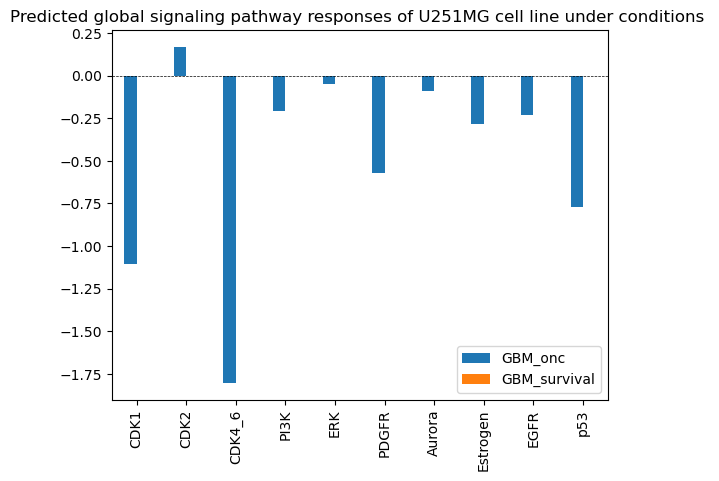

In [41]:
t_df_subset.plot.bar()
plt.axhline(y=0, linestyle='--', color='black',linewidth=0.5)
plt.title("Predicted global signaling pathway responses of U251MG cell line under conditions ")

In [42]:
rm_filt

,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53,GBM_onc,GBM_survival
CDK1,-1.000000,0.000000,0.478152,0.000000,-0.095940,0.000000,0.210483,0.00000,0.000000,0.000000,0.0,0.0
CDK2,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-0.032448,0.000000,0.0,0.0
CDK4_6,0.469560,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.066907,0.000000,0.0,0.0
PI3K,0.000000,0.000000,0.241437,-1.000000,0.280112,0.183693,0.000000,0.00000,0.000000,0.000000,0.0,0.0
ERK,0.000000,1.087506,0.000000,0.466211,-1.000000,0.000000,-0.153524,0.00000,0.209582,0.000000,0.0,0.0
PDGFR,0.000000,0.000000,0.000000,0.314703,0.000000,-1.000000,0.000000,0.49027,0.125584,0.000000,0.0,0.0
Aurora,0.561191,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.00000,0.256837,0.448555,0.0,0.0
Estrogen,0.000000,0.000000,0.000000,0.000000,0.000000,0.279787,0.000000,-1.00000,0.000000,0.000000,0.0,0.0
EGFR,0.000000,-0.958838,0.000000,0.000000,0.430357,0.000000,0.400726,0.00000,-1.000000,0.000000,0.0,0.0
p53,0.267452,0.000000,0.000000,0.000000,0.000000,0.000000,0.237525,0.00000,0.000000,-1.000000,0.0,0.0


In [43]:
display(rm_filt)
rm_subset=rm_filt[['CDK1', 'CDK2', 'CDK4_6', 'PI3K', 'ERK', 'PDGFR', 'Aurora','Estrogen', 'EGFR', 'p53']]

,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53,GBM_onc,GBM_survival
CDK1,-1.000000,0.000000,0.478152,0.000000,-0.095940,0.000000,0.210483,0.00000,0.000000,0.000000,0.0,0.0
CDK2,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-0.032448,0.000000,0.0,0.0
CDK4_6,0.469560,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.066907,0.000000,0.0,0.0
PI3K,0.000000,0.000000,0.241437,-1.000000,0.280112,0.183693,0.000000,0.00000,0.000000,0.000000,0.0,0.0
ERK,0.000000,1.087506,0.000000,0.466211,-1.000000,0.000000,-0.153524,0.00000,0.209582,0.000000,0.0,0.0
PDGFR,0.000000,0.000000,0.000000,0.314703,0.000000,-1.000000,0.000000,0.49027,0.125584,0.000000,0.0,0.0
Aurora,0.561191,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.00000,0.256837,0.448555,0.0,0.0
Estrogen,0.000000,0.000000,0.000000,0.000000,0.000000,0.279787,0.000000,-1.00000,0.000000,0.000000,0.0,0.0
EGFR,0.000000,-0.958838,0.000000,0.000000,0.430357,0.000000,0.400726,0.00000,-1.000000,0.000000,0.0,0.0
p53,0.267452,0.000000,0.000000,0.000000,0.000000,0.000000,0.237525,0.00000,0.000000,-1.000000,0.0,0.0


In [44]:
rm_subset

,CDK1,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53
CDK1,-1.000000,0.000000,0.478152,0.000000,-0.095940,0.000000,0.210483,0.00000,0.000000,0.000000
CDK2,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-0.032448,0.000000
CDK4_6,0.469560,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.066907,0.000000
PI3K,0.000000,0.000000,0.241437,-1.000000,0.280112,0.183693,0.000000,0.00000,0.000000,0.000000
ERK,0.000000,1.087506,0.000000,0.466211,-1.000000,0.000000,-0.153524,0.00000,0.209582,0.000000
PDGFR,0.000000,0.000000,0.000000,0.314703,0.000000,-1.000000,0.000000,0.49027,0.125584,0.000000
Aurora,0.561191,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.00000,0.256837,0.448555
Estrogen,0.000000,0.000000,0.000000,0.000000,0.000000,0.279787,0.000000,-1.00000,0.000000,0.000000
EGFR,0.000000,-0.958838,0.000000,0.000000,0.430357,0.000000,0.400726,0.00000,-1.000000,0.000000
p53,0.267452,0.000000,0.000000,0.000000,0.000000,0.000000,0.237525,0.00000,0.000000,-1.000000


In [45]:
rm_subset=rm_subset.loc[['GBM_onc','GBM_survival']]
rm_subset=rm_subset.T
display(rm_subset)

,GBM_onc,GBM_survival
CDK1,0.000000,0.0
CDK2,0.000000,0.0
CDK4_6,-1.226217,0.0
PI3K,0.000000,0.0
ERK,0.000000,0.0
PDGFR,-0.453007,0.0
Aurora,0.412284,0.0
Estrogen,0.000000,0.0
EGFR,0.000000,0.0
p53,-0.736213,0.0


Text(0.5, 1.0, 'Predicted local signaling pathway responses of U251MG cell line under conditions ')

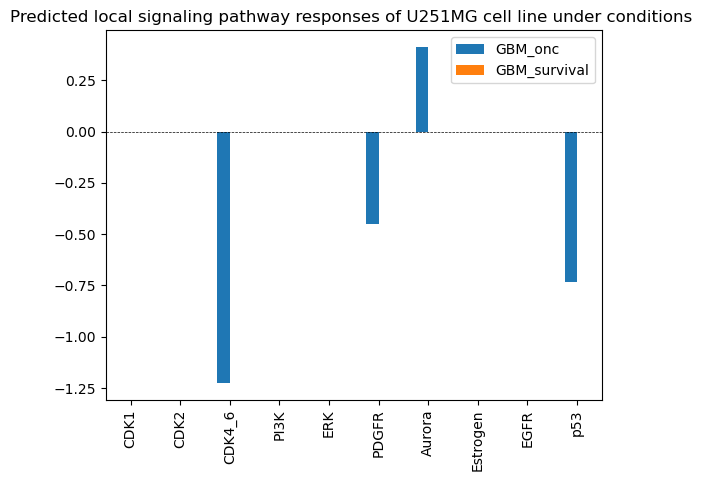

In [46]:
rm_subset.plot.bar()
plt.axhline(y=0, linestyle='--', color='black',linewidth=0.5)
plt.title("Predicted local signaling pathway responses of U251MG cell line under conditions ")